# K-means Clustering and Principal Component Analysis

## 2 Principal Component Analysis

### 2.1 Example Dataset

In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.misc import imread
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = scipy.io.loadmat('data/ex7data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [3]:
X = data['X']
X.shape

(50, 2)

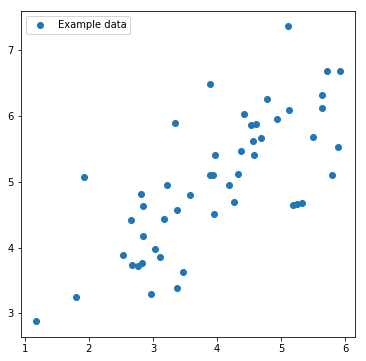

In [4]:
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], label='Example data')
plt.legend()
plt.show()

We can see that our data is much more varied in one direction than the other. We're going to use PCA to reduce the data from 2D to 1D.

### 2.2 Implementing PCA

In [5]:
def feature_normalise(X):
    '''
    Returns a normalized version of X where the mean value
    of each feature (column) is 0 and the standard deviation is 1.
    '''
    
    mu = np.mean(X, axis=0)
    X_norm = X - mu
    
    sigma = np.std(X_norm, axis=0)
    X_norm = X_norm / sigma
    
    return X_norm, mu, sigma

In [6]:
# Normalise X
X_norm, mu, sigma = feature_normalise(X)

In [7]:
def pca(X):
    '''
    Computes eigenvectors of the covariance matrix of X.
    Returns the eigenvectors U, and eigenvalues S.
    '''
    
    m, n = X.shape
    
    # Compute covariance matrix
    Sigma = 1/m * np.dot(X.T, X)
    
    U, S, V = np.linalg.svd(Sigma)
    
    return U, S

In [8]:
U, S = pca(X_norm)

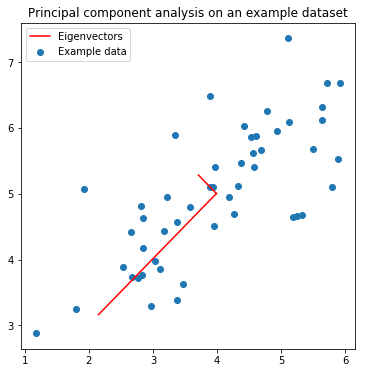

In [9]:
# Draw eigenvectors centred at mean of data
# These show the directions of maximum variations in the dataset.

# My 'mu' and 'U' arrays are of the form (mu_x, mu_y) and (U_x, U_y).
# Need to rearrange things a bit for matplotlib, which expects all
# the x values in one array and all the y values in another array, like:
# plt.plot(X, Y)

eigen_vect1 = np.vstack([mu, mu + 1.5 * S[0] * U[:,0].T])

# eigen_vect1 is of the form
#
# array([[x1, y1]
#        [x2, y2]])
#
# where [x1, y1] is the mean and
# [x2, y2] is mean plus 1.5 * eigenvalue * eigenvector
# 1.5 scaling is just to make lines more visible on plot

eigen_vect2 = np.vstack([mu, mu + 1.5 * S[1] * U[:,1].T])

plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], label='Example data')
plt.plot(eigen_vect1[:, 0], eigen_vect1[:, 1], c='r', label='Eigenvectors')
plt.plot(eigen_vect2[:, 0], eigen_vect2[:, 1], c='r')
plt.title('Principal component analysis on an example dataset')
plt.legend()
plt.show()

### 2.3 Dimensionality Reduction with PCA

"...you will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space"

#### 2.3.1 Projecting the data onto the principal components

In [10]:
def project_data(X, U, K):
    
    '''
    Computes the projection of normalized inputs X
    into reduced dimensional space spanned by
    the first K columns of principal components U.
    Returns the projected examples in Z.
    '''
    
    Z = np.zeros([X.shape[0], K])
    
    U_reduce = U[:, 0:K]
    Z = np.dot(X, U_reduce)
    
    return Z

In [11]:
K = 1
Z = project_data(X_norm, U, K)

print('Projection of the first example:', Z[0]);
print('(this value should be about ±1.481274)');

Projection of the first example: [ 1.49631261]
(this value should be about ±1.481274)


Slight difference from expected value, presumably because np.linalg.svd() isn't exactly the same as Matlab's SVD.

#### 2.3.2 Reconstructing an approximation of the data

In [12]:
def recover_data(Z, U, K):
    '''
    For Z, an array of data that has been projected onto the first
    K principal components in array U, recovers an approximation of
    the original data.
    Returns the approximate reconstruction in X_rec.
    '''
    
    U_reduce = U[:, 0:K]
    X_rec = np.dot(Z, U_reduce.T)

    return X_rec

In [13]:
X_rec  = recover_data(Z, U, K)
print('Approximation of the first example:', X_rec[0])
print('(this value should be about  -1.047419 -1.047419)');

Approximation of the first example: [-1.05805279 -1.05805279]
(this value should be about  -1.047419 -1.047419)


Again, sight difference from expected value, presumably because np.linalg.svd() isn't exactly the same as Matlab's SVD.

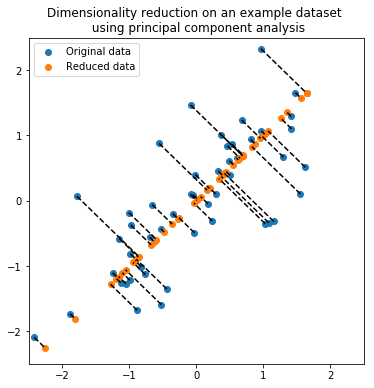

In [14]:
# Draw lines connecting projected points to original points

plt.figure(figsize=(6,6))
plt.scatter(X_norm[:, 0], X_norm[:, 1], label='Original data')
plt.scatter(X_rec[:, 0], X_rec[:, 1], label='Reduced data')

for i in range(X_norm.shape[0]):
    line_vec = np.vstack([X_norm[i], X_rec[i]])
    plt.plot(line_vec[:, 0], line_vec[:, 1], 'k--')

plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.title('Dimensionality reduction on an example dataset \n using principal component analysis')
plt.legend()
plt.show()

Comparing this plot with the plot of the principal components in the earlier plot, we can see that the projected data only preserves position along the first eigenvector.

### 2.4 Face Image Dataset

"...you will run PCA on face images to see how it can be used in practice for dimension reduction."

In [15]:
data = scipy.io.loadmat('data/ex7faces.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X'])

In [16]:
X = data['X']
X.shape

(5000, 1024)

X contains 5,000 pictures of faces, each of 32x32 = 1024 pixels. Let's look at the first 100 images.

In [17]:
def display_data(X):
    '''
    Displays 2D data stored in X in a nice grid.
    '''
    m = X.shape[0] # number of images
    display_rows = math.floor(math.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    n = X.shape[1] # pixels per image
    image_side = int(math.sqrt(n))
    
    plt.figure(figsize=(8,8))
    
    for i in range(m):
        image = X[i]
        image = np.reshape(image, (image_side, image_side), order='F')
        plt.subplot(display_rows, display_cols, i+1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

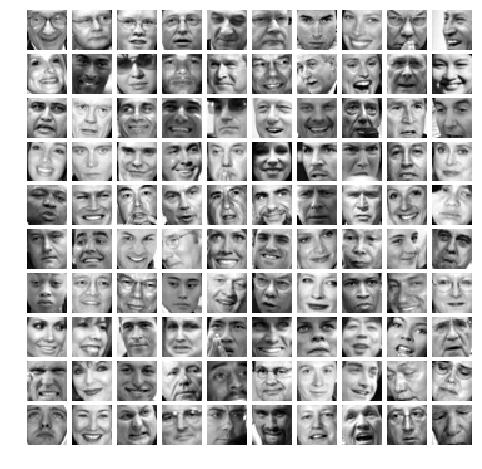

In [18]:
display_data(X[:100])

#### 2.4.1 PCA on Faces

In [19]:
X_norm, mu, sigma = feature_normalise(X)
U, S = pca(X_norm)

Eigenfaces!
First 36 principal components of a set of 5,000 images of faces


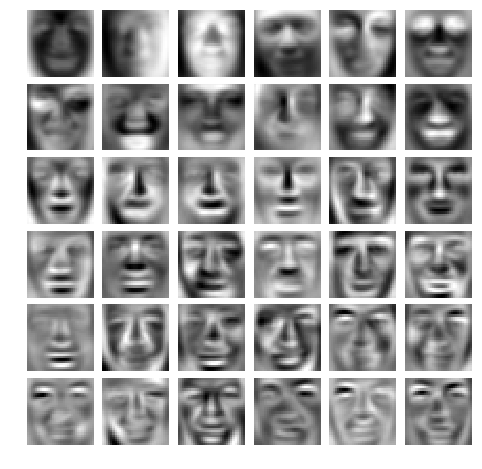

In [20]:
# Visualize first 36 eigenvectors (principal components)
print('Eigenfaces!')
print('First 36 principal components of a set of 5,000 images of faces')
display_data(U[:, :36].T)

#### 2.4.2 Dimensionality Reduction

In [21]:
# Project face dataset onto first 100 principal components
K = 100
Z = project_data(X_norm, U, K)

In [22]:
# Recover faces from reduced data
K = 100
X_rec = recover_data(Z, U, K)

Original faces:


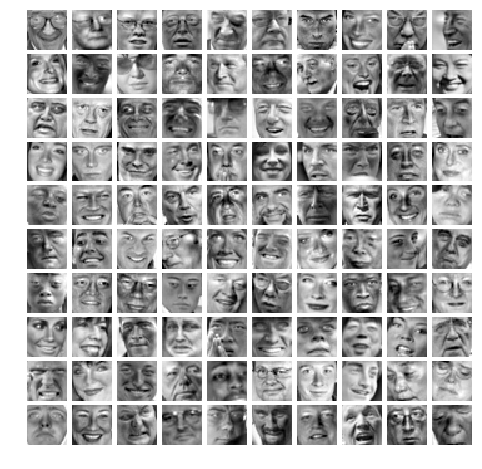

Reconstructed (compressed) faces, reduced in size by a factor of ten using PCA:


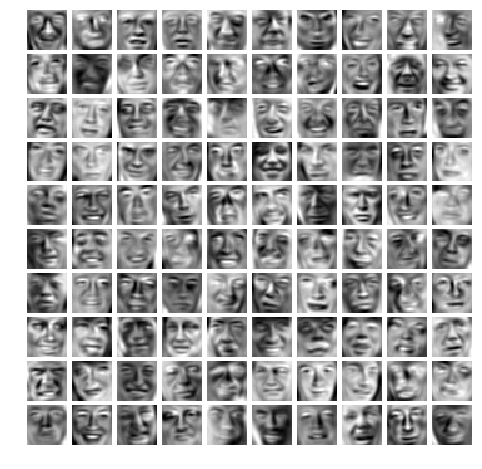

In [23]:
# Compare original and compressed faces

print('Original faces:')
display_data(X_norm[:100])

print('Reconstructed (compressed) faces, reduced in size by a factor of ten using PCA:')
display_data(X_rec[:100])

We see we've kept the major features of the faces while reducing the size of the data by a factor of ten, although we have lost some fine detail.

### 2.5 Optional exercise: PCA for visualization

We're going to use the image of the bird from Ex 7.1. To demonstrate using PCA for visualisation (via dimensionality reduction), we're going to plot every pixel of this image in a 3D RGB colour space, then reduce this visualisation to 2D.

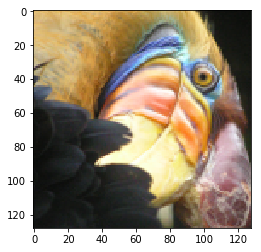

In [24]:
# Load image
img = imread('data/bird_small.png')
plt.imshow(img)
plt.show()

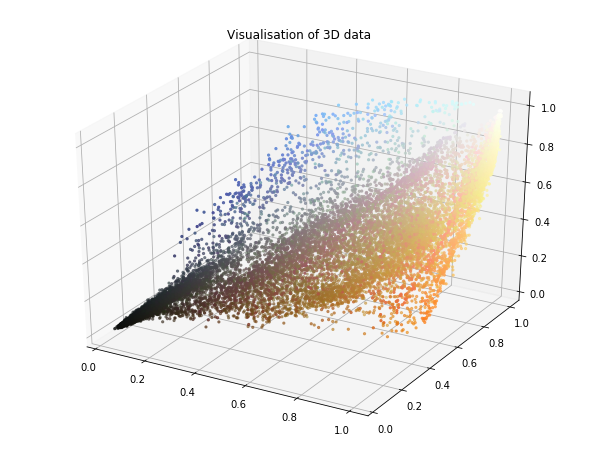

In [25]:
# Plot in 3D

A = img
A = A / 255 # divide by 255 so all colour values are in range 0-1.

# Reshape the image into an Nx3 matrix where N = number of pixels.
# Each row will contain the red, green and blue pixel values.
X = np.reshape(A, [A.shape[0] * A.shape[1], 3])

# Visualise in 3D
fig = plt.figure(figsize=(8,6))
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], marker='.', c=X)
plt.title('Visualisation of 3D data')
plt.show()

In [26]:
# Use PCA to reduce to 2D
X_norm, mu, sigma = feature_normalise(X)
[U, S] = pca(X_norm)
Z = project_data(X_norm, U, 2)

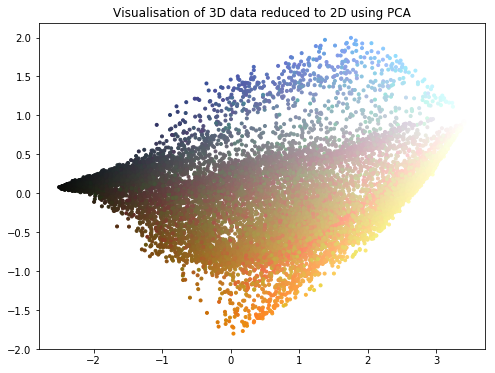

In [27]:
# And visualise in 2D
plt.figure(figsize=(8,6))
plt.scatter(-1*Z[:, 0], -1*Z[:, 1], marker='.', c=X)
# -1's to flip the eigenvectors,
# makes it easier to compare to the 3D plot
plt.title('Visualisation of 3D data reduced to 2D using PCA')
plt.show()